<a href="https://colab.research.google.com/github/32goqud/Korean/blob/master/customer_churn_prediction_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 캐글 데이터 등록 및 연동하기

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c customer-churn-prediction-2020

  0% 0.00/6.04k [00:00<?, ?B/s]
100% 6.04k/6.04k [00:00<00:00, 10.4MB/s]
  0% 0.00/383k [00:00<?, ?B/s]
100% 383k/383k [00:00<00:00, 52.4MB/s]
  0% 0.00/68.4k [00:00<?, ?B/s]
100% 68.4k/68.4k [00:00<00:00, 60.5MB/s]


In [ ]:
!ls

kaggle.json  sample_data  sampleSubmission.csv	test.csv  train.csv


# 패키지 및 데이터 등록

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import OrdinalEncoder, normalize
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
import torch
from torch.utils.data import DataLoader
import math
from tqdm import tqdm

import pandas as pd # load and manipulate data and for One-Hot Encoding
import numpy as np # calculate the mean and standard deviation
import xgboost as xgb # XGBoost stuff
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # for scoring during cross validation
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

df_test2 = pd.read_csv('test.csv')
df = pd.read_csv('train.csv')

In [ ]:
# data 설명
print(df.columns)

'''
상태, 문자열. 미국 고객 거주주의 2 자리 코드
account_length, 숫자. 고객이 현재 통신 제공 업체에서 근무한 개월 수
area_code, string = "area_code_AAA"여기서 AAA = 3 자리 지역 코드입니다.
international_plan, (예 / 아니오). 고객은 국제 계획을 가지고 있습니다.
voice_mail_plan, (예 / 아니오). 고객에게 음성 메일 요금제가 있습니다.
number_vmail_messages, 숫자. 음성 메일 메시지 수입니다.
# total_day_minutes, 숫자. 총 통화 시간 (분).
total_day_calls, 숫자. 총 일일 통화 수입니다.
total_day_charge, 숫자. 당일 통화 총 요금.
# total_eve_minutes, 숫자. 총 저녁 통화 시간입니다.
total_eve_calls, 숫자. 총 저녁 통화 수입니다.
total_eve_charge, 숫자. 저녁 통화의 총 요금.
# total_night_minutes, 숫자. 총 야간 통화 시간 (분).
total_night_calls, 숫자. 총 야간 통화 수입니다.
total_night_charge, 숫자. 야간 통화 총 요금.
total_intl_minutes, 숫자. 총 국제 전화 시간 (분).
total_intl_calls, 숫자. 총 국제 전화 수입니다.
total_intl_charge, 숫자. 국제 전화 총 요금
number_customer_service_calls, 숫자. 고객 서비스 호출 횟수
이탈, (예 / 아니요). 고객 이탈-목표 변수.
'''

Index(['state', 'account_length', 'area_code', 'international_plan',
       'voice_mail_plan', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'churn'],
      dtype='object')


'\n상태, 문자열. 미국 고객 거주주의 2 자리 코드\naccount_length, 숫자. 고객이 현재 통신 제공 업체에서 근무한 개월 수\narea_code, string = "area_code_AAA"여기서 AAA = 3 자리 지역 코드입니다.\ninternational_plan, (예 / 아니오). 고객은 국제 계획을 가지고 있습니다.\nvoice_mail_plan, (예 / 아니오). 고객에게 음성 메일 요금제가 있습니다.\nnumber_vmail_messages, 숫자. 음성 메일 메시지 수입니다.\n# total_day_minutes, 숫자. 총 통화 시간 (분).\ntotal_day_calls, 숫자. 총 일일 통화 수입니다.\ntotal_day_charge, 숫자. 당일 통화 총 요금.\n# total_eve_minutes, 숫자. 총 저녁 통화 시간입니다.\ntotal_eve_calls, 숫자. 총 저녁 통화 수입니다.\ntotal_eve_charge, 숫자. 저녁 통화의 총 요금.\n# total_night_minutes, 숫자. 총 야간 통화 시간 (분).\ntotal_night_calls, 숫자. 총 야간 통화 수입니다.\ntotal_night_charge, 숫자. 야간 통화 총 요금.\ntotal_intl_minutes, 숫자. 총 국제 전화 시간 (분).\ntotal_intl_calls, 숫자. 총 국제 전화 수입니다.\ntotal_intl_charge, 숫자. 국제 전화 총 요금\nnumber_customer_service_calls, 숫자. 고객 서비스 호출 횟수\n이탈, (예 / 아니요). 고객 이탈-목표 변수.\n'

# model 1 (xgboost, obj to float)

[0]	validation_0-aucpr:0.68981
Will train until validation_0-aucpr hasn't improved in 50 rounds.
[1]	validation_0-aucpr:0.68981
[2]	validation_0-aucpr:0.68981
[3]	validation_0-aucpr:0.68981
[4]	validation_0-aucpr:0.68981
[5]	validation_0-aucpr:0.68981
[6]	validation_0-aucpr:0.68981
[7]	validation_0-aucpr:0.68981
[8]	validation_0-aucpr:0.68981
[9]	validation_0-aucpr:0.68981
[10]	validation_0-aucpr:0.68981
[11]	validation_0-aucpr:0.68981
[12]	validation_0-aucpr:0.68981
[13]	validation_0-aucpr:0.68981
[14]	validation_0-aucpr:0.68981
[15]	validation_0-aucpr:0.68981
[16]	validation_0-aucpr:0.68981
[17]	validation_0-aucpr:0.68981
[18]	validation_0-aucpr:0.68981
[19]	validation_0-aucpr:0.68981
[20]	validation_0-aucpr:0.68981
[21]	validation_0-aucpr:0.68981
[22]	validation_0-aucpr:0.68981
[23]	validation_0-aucpr:0.68981
[24]	validation_0-aucpr:0.68981
[25]	validation_0-aucpr:0.68981
[26]	validation_0-aucpr:0.68981
[27]	validation_0-aucpr:0.68981
[28]	validation_0-aucpr:0.68981
[29]	validation_

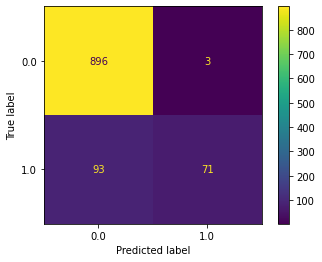

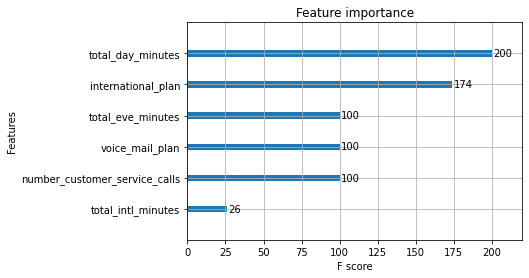

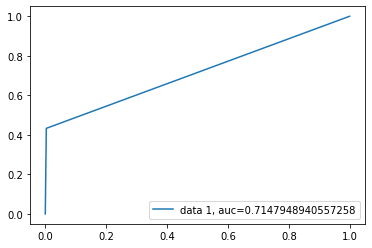

In [ ]:
df1 = df.copy()
columns = ["state", "area_code", "international_plan", "voice_mail_plan", "churn"]
encoder = OrdinalEncoder()
df1[columns] = encoder.fit_transform(df1[columns])
X = df1.iloc[:,0:-1]
y = df1.iloc[:,-1]
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True)

model = xgb.XGBClassifier(learning_rate=0.001)
model.fit(X_train, 
            y_train, 
            verbose=True, 
            early_stopping_rounds=50,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

y_probas = model.predict(X_test)

accuracy = (y_probas == y_test).sum().astype(float) / len(y_probas)*100

print("XGBoost's prediction accuracy with optimal hyperparameters is: %3.2f" % (accuracy))

plot_confusion_matrix(model, 
                      X_test, 
                      y_test,
                      values_format='d')
plt.show()

from xgboost import plot_importance
plot_importance(model, max_num_features=20) # top 10 most important features
plt.show()

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_probas)
auc = metrics.roc_auc_score(y_test, y_probas)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# model 2 (ensemble)

In [ ]:

from sklearn.preprocessing import LabelEncoder

df3 = df.copy()
best_col = ['total_day_minutes','voice_mail_plan','number_customer_service_calls','international_plan', 'churn']
df3 = df3[best_col]
df3 = pd.get_dummies(df3,columns=['voice_mail_plan','international_plan'])

X = df3.drop('churn',axis=1)
y = df3.churn

encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True)

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import accuracy_score

space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print("SCORE : ", accuracy, 'loss', -accuracy )
    return {'loss': -accuracy, 'status': STATUS_OK }


trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964252116
SCORE : 
0.8494825964252116
loss
-0.8494825964

In [ ]:
hp.quniform("max_depth", 3, 18, 1)

[0]	validation_0-aucpr:0.625407
Will train until validation_0-aucpr hasn't improved in 50 rounds.
[1]	validation_0-aucpr:0.625407
[2]	validation_0-aucpr:0.625407
[3]	validation_0-aucpr:0.625407
[4]	validation_0-aucpr:0.625407
[5]	validation_0-aucpr:0.625407
[6]	validation_0-aucpr:0.625932
[7]	validation_0-aucpr:0.625932
[8]	validation_0-aucpr:0.625932
[9]	validation_0-aucpr:0.625932
[10]	validation_0-aucpr:0.625932
[11]	validation_0-aucpr:0.625932
[12]	validation_0-aucpr:0.625932
[13]	validation_0-aucpr:0.625932
[14]	validation_0-aucpr:0.626405
[15]	validation_0-aucpr:0.626405
[16]	validation_0-aucpr:0.626405
[17]	validation_0-aucpr:0.626405
[18]	validation_0-aucpr:0.626405
[19]	validation_0-aucpr:0.626405
[20]	validation_0-aucpr:0.626405
[21]	validation_0-aucpr:0.626405
[22]	validation_0-aucpr:0.626405
[23]	validation_0-aucpr:0.626405
[24]	validation_0-aucpr:0.626405
[25]	validation_0-aucpr:0.63092
[26]	validation_0-aucpr:0.63092
[27]	validation_0-aucpr:0.632764
[28]	validation_0-aucp

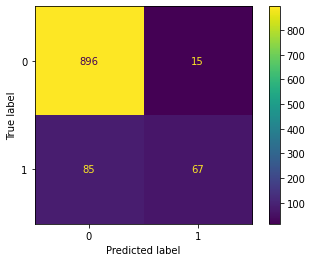

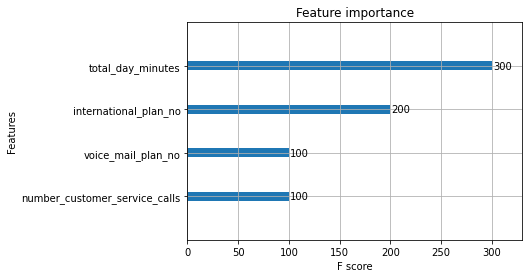

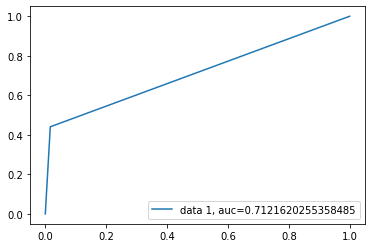

In [ ]:
from sklearn.preprocessing import LabelEncoder
df3 = df.copy()
best_col = ['total_day_minutes','voice_mail_plan','number_customer_service_calls','international_plan', 'churn']
df3 = df3[best_col]
df3 = pd.get_dummies(df3,columns=['voice_mail_plan','international_plan'])
X = df3.drop('churn',axis=1)
y = df3.churn
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True)

model = xgb.XGBClassifier(learning_rate=0.01)
model.fit(X_train, 
            y_train, 
            verbose=True, 
            early_stopping_rounds=50,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])

y_probas = model.predict(X_test)

accuracy = (y_probas == y_test).sum().astype(float) / len(y_probas)*100

print("XGBoost's prediction accuracy with optimal hyperparameters is: %3.2f" % (accuracy))

plot_confusion_matrix(model, 
                      X_test, 
                      y_test,
                      values_format='d')
plt.show()

from xgboost import plot_importance
plot_importance(model, max_num_features=10) # top 10 most important features
plt.show()

from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_probas)
auc = metrics.roc_auc_score(y_test, y_probas)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Feature engineering

## groupby

In [ ]:
for i in columns_obj[0:-1]:
    df1 = pd.get_dummies(df[[i, columns_obj[-1]]], columns = [columns_obj[-1]])
    df1 = df1.groupby(i).sum()
    df1[i + '_rate'] = df1.iloc[:,1] / (df1.iloc[:,0] + df1.iloc[:,1]) * 100
    print(df1.sort_values(i + '_rate',ascending=False).head(5))

       churn_0.0  churn_1.0  state_rate
state                                  
31.0          70         26   27.083333
4.0           29         10   25.641026
47.0          62         18   22.500000
20.0          67         19   22.093023
26.0          63         17   21.250000
           churn_0.0  churn_1.0  area_code_rate
area_code                                      
2.0            897.0      159.0       15.056818
0.0            934.0      152.0       13.996317
1.0           1821.0      287.0       13.614801
                    churn_0.0  churn_1.0  international_plan_rate
international_plan                                               
1.0                     229.0      167.0                42.171717
0.0                    3423.0      431.0                11.183186
                 churn_0.0  churn_1.0  voice_mail_plan_rate
voice_mail_plan                                            
0.0                 2622.0      516.0             16.443595
1.0                 1030.0       82.

- confusion matrix 결과로 실제1,예측0의 경우 rate가 낮다
- 실제1일 경우의 class에 대한 데이터를 분리하여 인사이트를 발굴한다
- international_plan 1, churn 1 조합의 비율이 가장 많다.
- 따라서 해당 항목에 대한 분류로 새로운 feature를 생성한다

## overlay

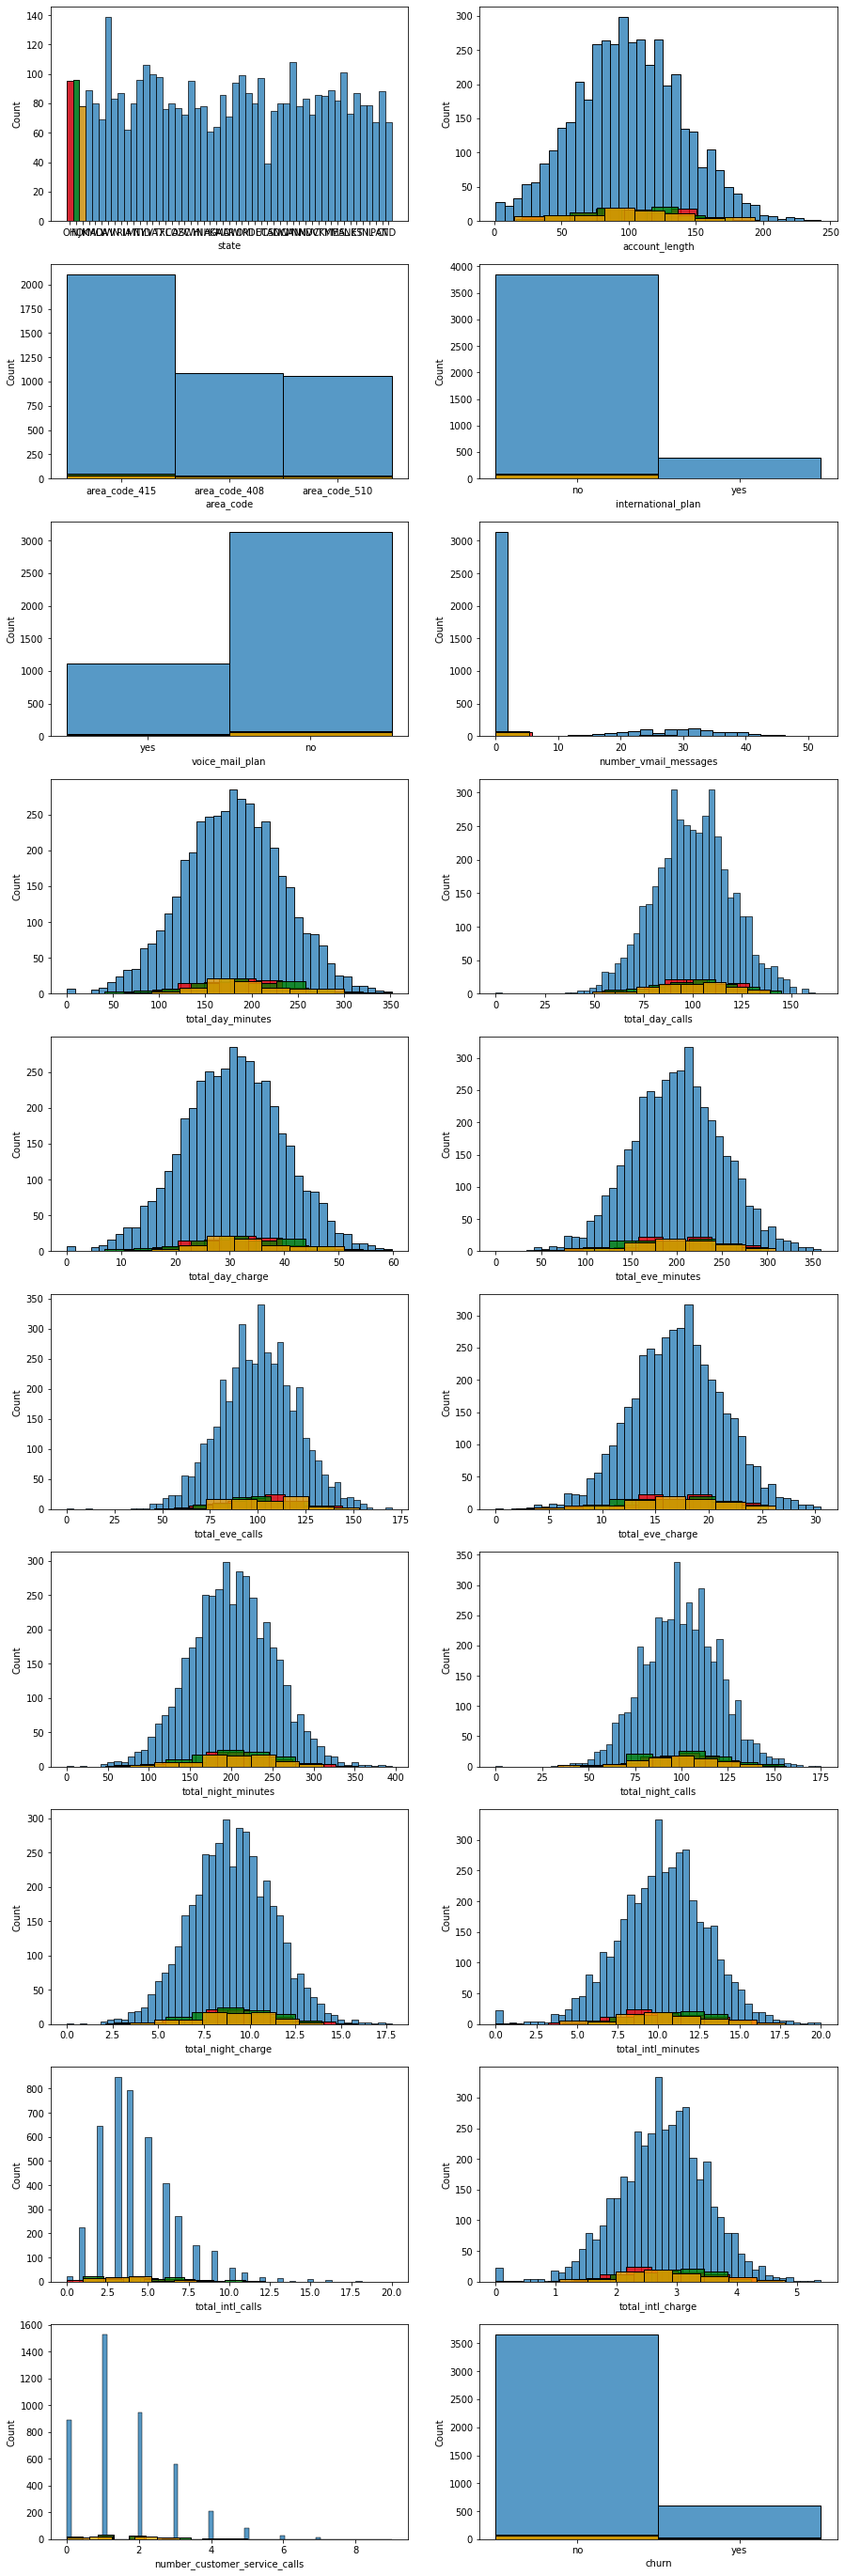

In [ ]:
df1 = df[df.state==df.state.unique()[0]]
df2 = df[df.state==df.state.unique()[1]]
df3 = df[df.state==df.state.unique()[2]]

fig = plt.figure(figsize=(15,100))
for cnt,i in enumerate(df1.columns):

    try:
        plt.subplot(20, 2, cnt+1)
        sns.histplot(df[i])
        sns.histplot(df1[i],color='red')
        sns.histplot(df2[i],color='green')
        sns.histplot(df3[i],color='orange')
    except:
        continue
plt.show()

- raw data와 international_plan이 1일 데이터를 overlay하였음
- number_vmail_messages가 전부 0이 나온다
- 다음 단계는 두 독립변수에 대한 데이터셋을 구성하여 경향을 파악한다


In [ ]:
df1 = df[(df.international_plan==1) & (df.number_vmail_messages==0)]
df1

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
2,35.0,84,0.0,1.0,0.0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0.0
3,36.0,75,1.0,1.0,0.0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0.0
5,24.0,147,1.0,1.0,0.0,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,0.0
53,50.0,43,1.0,1.0,0.0,0,251.5,105,42.76,212.8,104,18.09,157.8,67,7.10,9.3,4,2.51,0,0.0
54,23.0,113,0.0,1.0,0.0,0,125.2,93,21.28,206.4,119,17.54,129.3,139,5.82,8.3,8,2.24,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4179,28.0,38,1.0,1.0,0.0,0,211.6,87,35.97,106.9,68,9.09,239.2,99,10.76,14.1,11,3.81,0,1.0
4180,31.0,77,1.0,1.0,0.0,0,323.7,106,55.03,139.2,99,11.83,204.4,89,9.20,8.5,3,2.30,6,1.0
4193,47.0,62,1.0,1.0,0.0,0,180.9,121,30.75,134.3,107,11.42,179.3,74,8.07,8.6,2,2.32,2,1.0
4213,32.0,137,0.0,1.0,0.0,0,312.4,110,53.11,231.1,73,19.64,120.1,78,5.40,10.6,2,2.86,1,1.0


,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
2,35.0,84,0.0,1.0,0.0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0.0
3,36.0,75,1.0,1.0,0.0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0.0
5,24.0,147,1.0,1.0,0.0,0,157.0,79,26.69,103.1,94,8.76,211.8,96,9.53,7.1,6,1.92,0,0.0
7,49.0,141,1.0,1.0,1.0,37,258.6,84,43.96,222.0,111,18.87,326.4,97,14.69,11.2,5,3.02,0,0.0
30,0.0,136,1.0,1.0,1.0,33,203.9,106,34.66,187.6,99,15.95,101.7,107,4.58,10.5,6,2.84,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4193,47.0,62,1.0,1.0,0.0,0,180.9,121,30.75,134.3,107,11.42,179.3,74,8.07,8.6,2,2.32,2,1.0
4203,30.0,114,2.0,1.0,1.0,28,136.4,93,23.19,170.0,90,14.45,191.5,73,8.62,14.6,4,3.94,2,1.0
4213,32.0,137,0.0,1.0,0.0,0,312.4,110,53.11,231.1,73,19.64,120.1,78,5.40,10.6,2,2.86,1,1.0
4217,20.0,47,1.0,1.0,1.0,31,140.6,114,23.90,264.6,44,22.49,238.7,121,10.74,9.7,4,2.62,2,0.0
